<a href="https://colab.research.google.com/github/LoQiseaking69/SephsBIOME/blob/master/Docs/Model/Tests/Utils/notebooks/SynthDGenV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic Dataset Generation for NLP and Robotic Kinematics

This notebook generates a synthetic dataset optimized for combined NLP and robotic kinematics tasks in a reinforcement learning model. The dataset includes both textual and sensor data, with feature engineering applied to enhance its suitability for machine learning tasks.

In [1]:
%%capture
!pip install markovify

## NLP Data Generation Using Brown Corpus

In [2]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import nltk
from nltk.corpus import brown
import markovify
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Download the 'brown' corpus from nltk
nltk.download('brown')

# Save the brown corpus to a CSV file
def save_brown_corpus(file_path):
    try:
        # Extracting sentences from the brown corpus
        brown_sentences = [' '.join(words) for words in brown.sents()]
        # Converting to DataFrame
        df = pd.DataFrame(brown_sentences, columns=['sentence'])
        # Saving to CSV
        df.to_csv(file_path, index=False)
        return "File saved successfully."
    except Exception as e:
        return f"Error saving file: {e}"

# Example usage
file_save_status = save_brown_corpus('brown_corpus.csv')
print(file_save_status)

# Function to read a CSV file
def read_csv_file(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        return "File not found."

# Example usage
csv_data = read_csv_file('brown_corpus.csv')
print(csv_data)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


File saved successfully.
                                                sentence
0      The Fulton County Grand Jury said Friday an in...
1      The jury further said in term-end presentments...
2      The September-October term jury had been charg...
3      `` Only a relative handful of such reports was...
4      The jury said it did find that many of Georgia...
...                                                  ...
57335                                     S. J. Perelman
57336                            revulsion in the desert
57337  the doors of the D train slid shut , and as I ...
57338  She was a living doll and no mistake -- the bl...
57339  From what I was able to gauge in a swift , gre...

[57340 rows x 1 columns]


In [3]:
# Generate text data using Markov chains built from the Brown corpus
text = ' '.join(brown.words())
text_model = markovify.Text(text)

def generate_text_data(num_samples):
    return [text_model.make_short_sentence(100) for _ in range(num_samples)]


## Synthetic Dataset Generation Function

In [4]:
# Function to generate text data from the brown corpus
def generate_text_data(num_samples):
    # Extracting sentences from the brown corpus
    brown_sentences = [' '.join(words) for words in brown.sents()]
    # Randomly selecting sentences to match the number of samples
    random_sentences = random.choices(brown_sentences, k=num_samples)
    return random_sentences

# Function to generate synthetic dataset
def generate_synthetic_dataset(num_samples=1000, num_sensors=128, num_actions=10, noise_level=0.05):
    timestamps = [datetime.now() + timedelta(seconds=i) for i in range(num_samples)]
    text_data = generate_text_data(num_samples)
    sensor_data = {}
    for i in range(num_sensors):
        period = np.random.randint(10, 100)
        sensor_data[f'sensor_{i}'] = np.sin(np.linspace(0, 2 * np.pi * period, num_samples)) + np.random.normal(0, noise_level, num_samples)
    action_data = np.random.randint(0, num_actions, num_samples)
    reward_data = np.random.uniform(-1, 1, num_samples)
    return pd.DataFrame({
        'timestamp': timestamps,
        'text_data': text_data,
        **sensor_data,
        'action': action_data,
        'reward': reward_data
    })

# Generate the dataset
synthetic_dataset = generate_synthetic_dataset()

# Save the dataset to a CSV file
synthetic_dataset.to_csv('SephsDataV3.csv', index=False)

# Inform that the file has been saved
print("Dataset saved as SephsDataV3.csv")

Dataset saved as SephsDataV3.csv


## Dataset Reorganization for Reinforcement Learning

Shape of CSV file: (4299, 512)


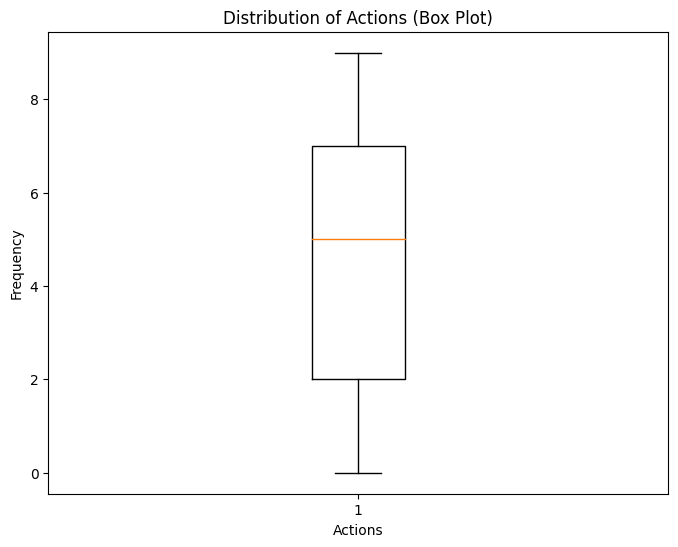

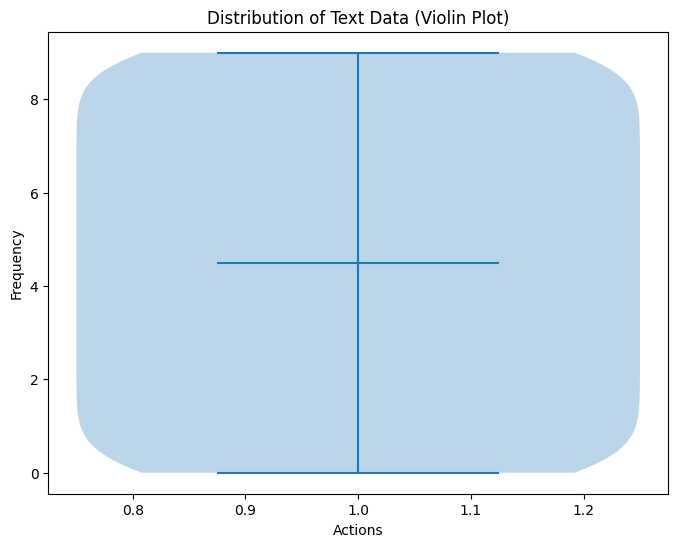

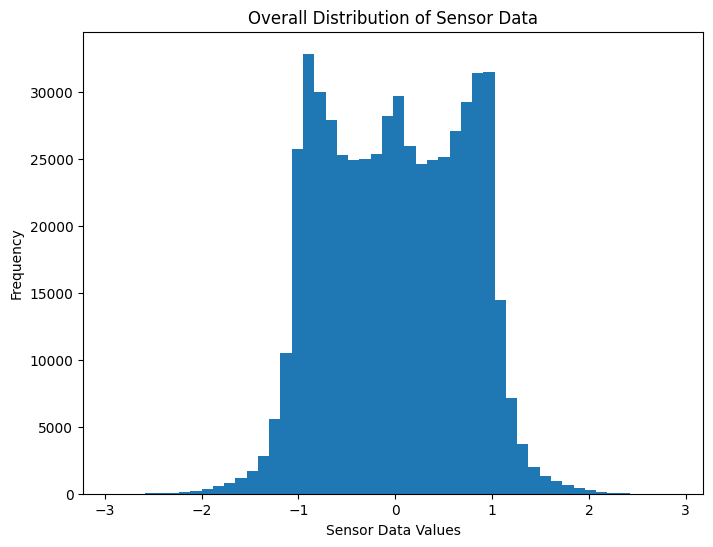

Shape of reorganized data: (4299, 512)
4    430
8    430
0    430
7    430
3    430
5    430
6    430
9    430
2    430
1    429
Name: action, dtype: int64


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def augment_data(sensor_data, actions, augment_ratio=0.5):
    augmented_sensor_data = []
    augmented_actions = []

    # Add original data
    augmented_sensor_data.append(sensor_data)
    augmented_actions.append(actions)

    # Noise injection with increased variability
    noise_strength = 0.5  # Increase noise strength for more variability
    noise = np.random.normal(0, noise_strength, sensor_data.shape)
    noisy_sensor_data = sensor_data + noise
    augmented_sensor_data.append(noisy_sensor_data)
    augmented_actions.append(actions)

    # Data replication with scaling and shifting
    for _ in range(2):
        replicated_sensor_data = sensor_data * np.random.uniform(0.8, 1.2, size=sensor_data.shape)  # Scale data
        replicated_sensor_data += np.random.uniform(-0.2, 0.2, size=sensor_data.shape)  # Shift data
        augmented_sensor_data.append(replicated_sensor_data)
        augmented_actions.append(actions)

    # Data interpolation
    interpolated_sensor_data = (sensor_data[:-1] + sensor_data[1:]) / 2
    augmented_sensor_data.append(interpolated_sensor_data)
    augmented_actions.append(actions[:-1])

    # Combine augmented data
    augmented_sensor_data = np.concatenate(augmented_sensor_data, axis=0)
    augmented_actions = pd.concat(augmented_actions, ignore_index=True)

    return augmented_sensor_data, augmented_actions

def reorganize_for_rl(df, seq_length=128, num_features=512, augment_ratio=0.5):
    # Assuming df has 128 sensor columns and 1 action column
    sensor_columns = [f'sensor_{i}' for i in range(seq_length)]
    action_column = 'action'
    action_counts = df[action_column].value_counts()
    min_count = action_counts.min()

    # Balance the dataset according to the action counts
    balanced_df = pd.concat([df[df[action_column] == action].sample(min_count, random_state=42) for action in action_counts.index])

    # Extract sensor data
    sensor_data = balanced_df[sensor_columns].to_numpy()

    # Augment data
    augmented_sensor_data, augmented_actions = augment_data(sensor_data, balanced_df[action_column], augment_ratio)

    # Pad each sensor reading to reach the desired number of features
    padded_data = np.zeros((augmented_sensor_data.shape[0], num_features))
    padded_data[:, :seq_length] = augmented_sensor_data

    # Save the 2-dimensional CSV file
    csv_file_path = "reorganized_data.csv"
    pd.DataFrame(padded_data).to_csv(csv_file_path, index=False)

    # Print the shape of the CSV file
    csv_data = pd.read_csv(csv_file_path)
    print("Shape of CSV file:", csv_data.shape)

    # Visualize the distribution of actions using a box plot
    plt.figure(figsize=(8, 6))
    plt.boxplot(augmented_actions)
    plt.xlabel('Actions')
    plt.ylabel('Frequency')
    plt.title('Distribution of Actions (Box Plot)')
    plt.show()

    # Visualize the distribution of text data using a violin plot
    plt.figure(figsize=(8, 6))
    plt.violinplot(balanced_df[action_column], showmeans=True)
    plt.xlabel('Actions')
    plt.ylabel('Frequency')
    plt.title('Distribution of Text Data (Violin Plot)')
    plt.show()

    # Visualize the overall distribution of sensor data
    plt.figure(figsize=(8, 6))
    plt.hist(augmented_sensor_data.flatten(), bins=50)
    plt.xlabel('Sensor Data Values')
    plt.ylabel('Frequency')
    plt.title('Overall Distribution of Sensor Data')
    plt.show()

    return padded_data, augmented_actions

# Read the dataset from the CSV file
df = pd.read_csv('/content/SephsDataV3.csv')

# Reorganize the dataset for reinforcement learning with data augmentation
reorganized_data, actions = reorganize_for_rl(df)

# Print the shape of the reorganized data to confirm it's 3D
print("Shape of reorganized data:", reorganized_data.shape)
# Print or use the actions as needed
print(actions.value_counts())

## Feature Engineering

Shape of CSV file: (4999, 512)


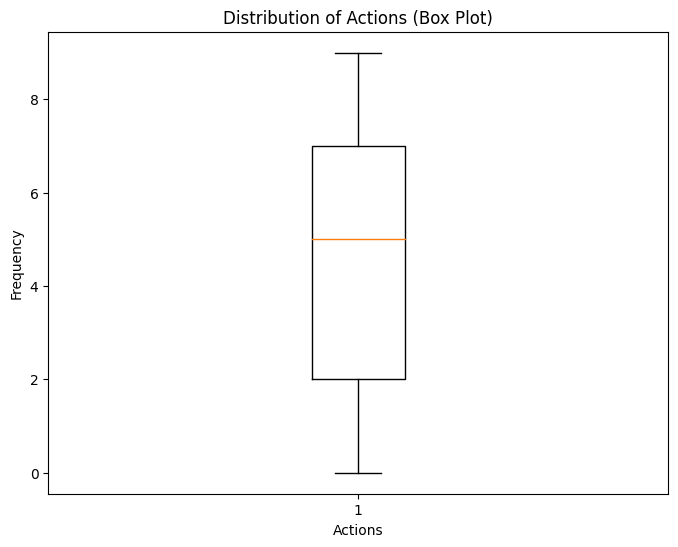

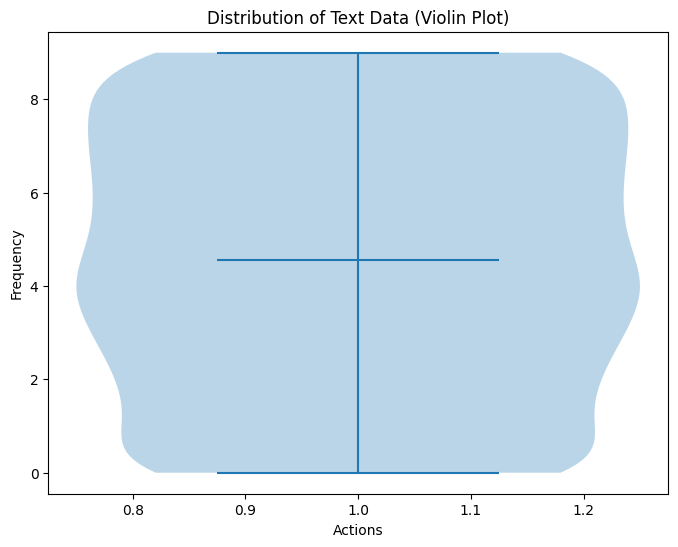

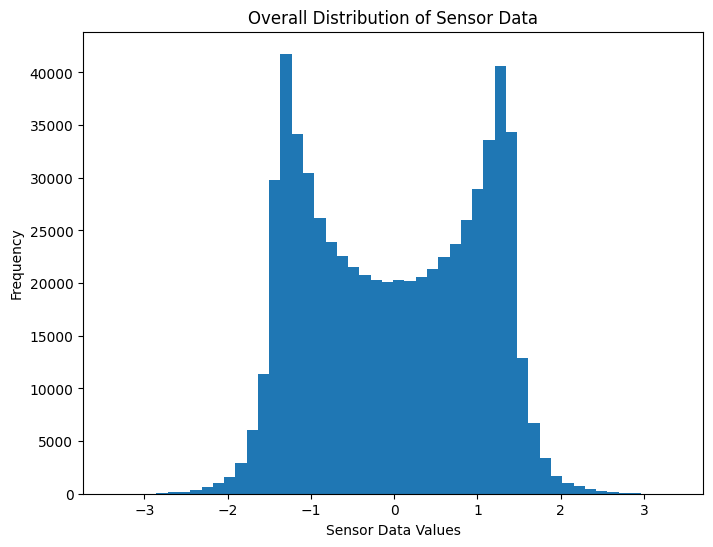

Shape of reorganized data: (4999, 512)
4    560
8    520
0    520
7    515
3    509
5    505
6    500
9    485
2    455
1    430
Name: action, dtype: int64


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

def feature_engineering(df, sensor_columns):
    # Standardize the sensor data and handle missing values
    scaler = StandardScaler()
    df[sensor_columns] = scaler.fit_transform(df[sensor_columns].fillna(method='ffill'))

    # Add random noise to introduce variability
    noise_strength = 0.01  # Adjust this value based on the desired level of noise
    noise = np.random.normal(0, noise_strength, df[sensor_columns].shape)
    df[sensor_columns] += noise

    return df

def preprocess_text_data(text_data, max_features):
    # Encode the 'text_data' using TF-IDF with advanced settings
    tfidf = TfidfVectorizer(max_features=max_features, ngram_range=(1, 2), stop_words='english')
    tfidf_features = tfidf.fit_transform(text_data).toarray()
    return tfidf_features

def augment_data(sensor_data, actions, augment_ratio=0.5):
    augmented_sensor_data = []
    augmented_actions = []

    # Add original data
    augmented_sensor_data.append(sensor_data)
    augmented_actions.append(actions)

    # Noise injection with increased variability
    noise_strength = 0.5  # Increase noise strength for more variability
    noise = np.random.normal(0, noise_strength, sensor_data.shape)
    noisy_sensor_data = sensor_data + noise
    augmented_sensor_data.append(noisy_sensor_data)
    augmented_actions.append(actions)

    # Data replication with scaling and shifting
    for _ in range(2):
        replicated_sensor_data = sensor_data * np.random.uniform(0.8, 1.2, size=sensor_data.shape)  # Scale data
        replicated_sensor_data += np.random.uniform(-0.2, 0.2, size=sensor_data.shape)  # Shift data
        augmented_sensor_data.append(replicated_sensor_data)
        augmented_actions.append(actions)

    # Data interpolation
    interpolated_sensor_data = (sensor_data[:-1] + sensor_data[1:]) / 2
    augmented_sensor_data.append(interpolated_sensor_data)
    augmented_actions.append(actions[:-1])

    # Combine augmented data
    augmented_sensor_data = np.concatenate(augmented_sensor_data, axis=0)
    augmented_actions = pd.concat(augmented_actions, ignore_index=True)

    return augmented_sensor_data, augmented_actions

def wrangle_data(file_path, seq_length=127, num_features=512, num_text_features=385):
    # Load the dataset
    data = pd.read_csv(file_path)

    # Handle missing values (if any)
    data.fillna(method='ffill', inplace=True)

    # List of sensor columns
    sensor_columns = [f'sensor_{i}' for i in range(seq_length)]

    # Apply feature engineering to sensor data
    data = feature_engineering(data, sensor_columns)

    # Process the text data if it exists
    if 'text_data' in data.columns:
        text_data = data['text_data'].fillna('')  # Replace NaN values in text data
        tfidf_features = preprocess_text_data(text_data, num_text_features)

        # Check if the number of text features is not exceeding the available space
        if seq_length + num_text_features <= num_features:
            # Create DataFrame for text features
            text_features_df = pd.DataFrame(tfidf_features, columns=[f'text_feature_{i}' for i in range(tfidf_features.shape[1])])

            # Concatenate text features DataFrame with original DataFrame
            data = pd.concat([data, text_features_df], axis=1)
        else:
            raise ValueError("Number of sensors and text features exceeds the specified number of features, please adjust num_text_features.")

    # Augment data
    augmented_sensor_data, augmented_actions = augment_data(data[sensor_columns].to_numpy(), data['action'], augment_ratio=0.5)

    # Pad each sensor reading to reach the desired number of features
    padded_data = np.zeros((augmented_sensor_data.shape[0], num_features))
    padded_data[:, :seq_length] = augmented_sensor_data

    # Save the 2-dimensional CSV file
    csv_file_path = "reorganized_data.csv"
    pd.DataFrame(padded_data).to_csv(csv_file_path, index=False)

    # Print the shape of the CSV file
    csv_data = pd.read_csv(csv_file_path)
    print("Shape of CSV file:", csv_data.shape)

    # Visualize the distribution of actions using a box plot
    plt.figure(figsize=(8, 6))
    plt.boxplot(augmented_actions)
    plt.xlabel('Actions')
    plt.ylabel('Frequency')
    plt.title('Distribution of Actions (Box Plot)')
    plt.show()

    # Visualize the distribution of text data using a violin plot
    plt.figure(figsize=(8, 6))
    plt.violinplot(data['action'], showmeans=True)
    plt.xlabel('Actions')
    plt.ylabel('Frequency')
    plt.title('Distribution of Text Data (Violin Plot)')
    plt.show()

    # Visualize the overall distribution of sensor data
    plt.figure(figsize=(8, 6))
    plt.hist(augmented_sensor_data.flatten(), bins=50)
    plt.xlabel('Sensor Data Values')
    plt.ylabel('Frequency')
    plt.title('Overall Distribution of Sensor Data')
    plt.show()

    return padded_data, augmented_actions

# Usage
file_path = '/content/SephsDataV3.csv'  # Update to your file path
reorganized_data, actions = wrangle_data(file_path)

# Print the shape of the reorganized data to confirm it's 2D
print("Shape of reorganized data:", reorganized_data.shape)

# Print or use the actions as needed
print(actions.value_counts())

In [16]:
df = pd.read_csv('/content/SephsDataV3.csv')
df.head(3)

,timestamp,text_data,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_120,sensor_121,sensor_122,sensor_123,sensor_124,sensor_125,sensor_126,sensor_127,action,reward
0,2024-02-08 01:51:53.627863,At first they were only feathers and dark indi...,-0.068088,-0.067083,0.026157,-0.004288,-0.049346,0.042840,-0.003918,0.003730,...,0.011636,-0.103081,-0.009327,-0.023036,0.053134,0.036527,0.022162,0.069688,7,-0.661362
1,2024-02-08 01:51:54.627873,He fought the panic of vertigo .,0.448804,0.415607,0.150669,0.195678,0.259493,0.272144,0.201980,0.599807,...,0.177565,0.580425,0.265206,0.181860,0.370419,0.291942,0.243897,0.190316,8,0.894021
2,2024-02-08 01:51:55.627875,( 3 ) In other experiments the indirect conjug...,0.874041,0.841150,0.129580,0.354401,0.568224,0.610961,0.223507,0.894980,...,0.135564,0.942284,0.452395,0.259181,0.606073,0.499160,0.436650,0.350585,6,-0.015267


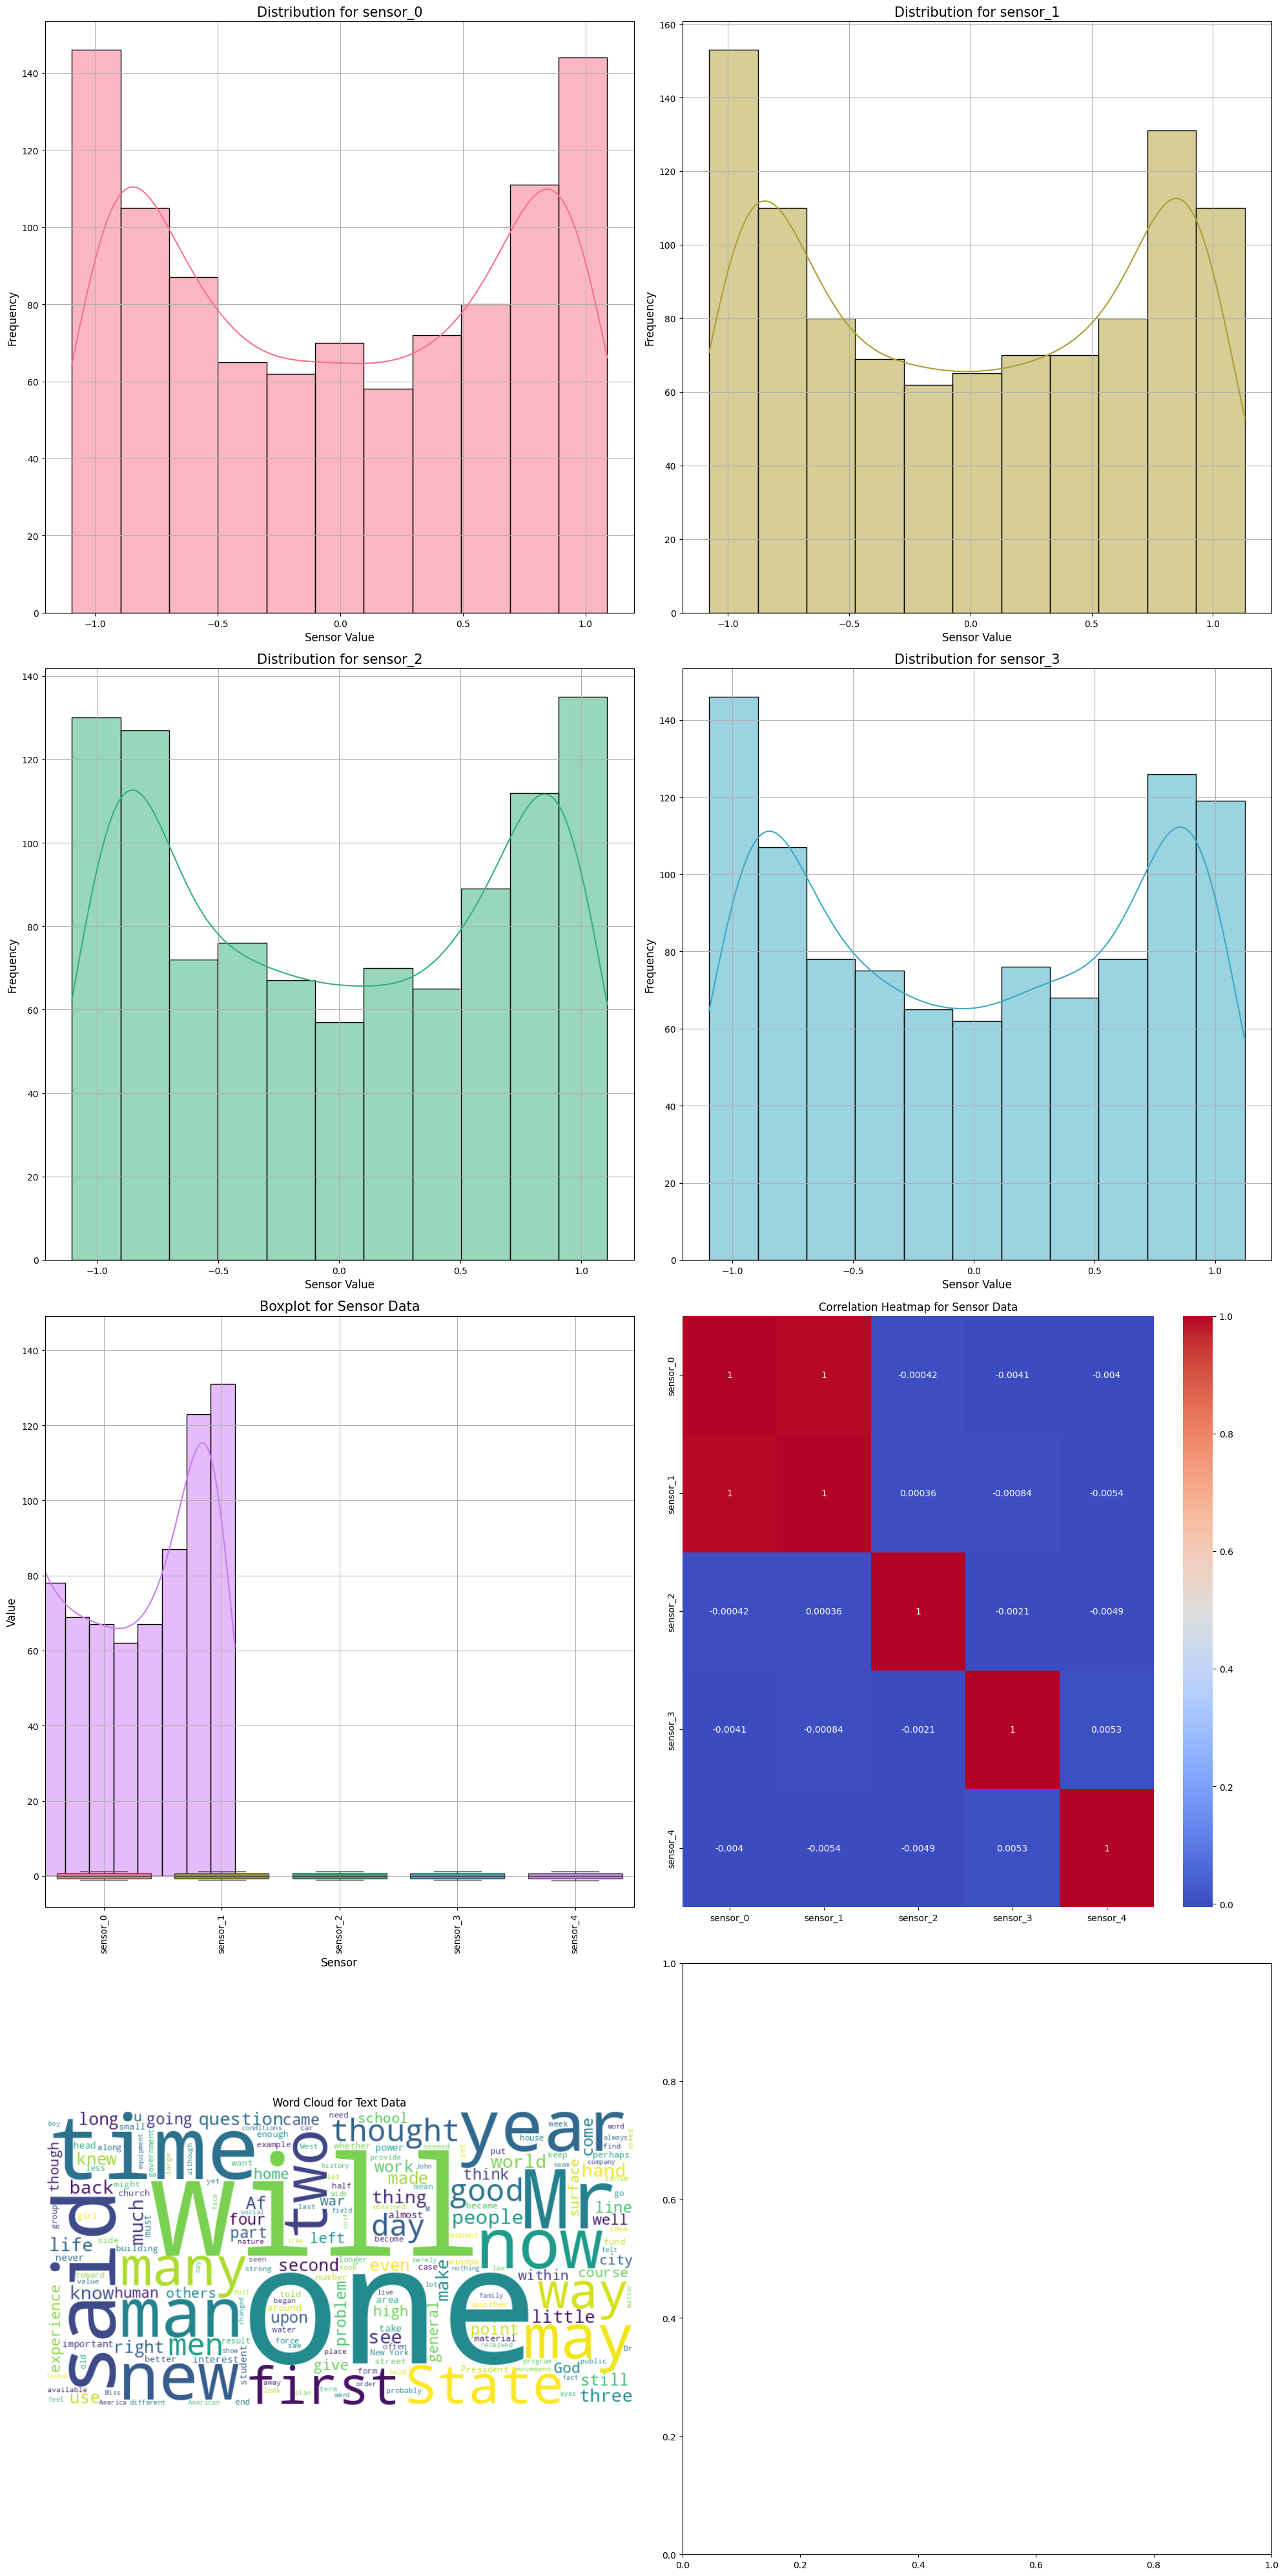

In [17]:
# Load the dataset
data = pd.read_csv('/content/SephsDataV3.csv')

# Visualization for Sensor Data
# Select only the first 5 sensor columns for demonstration
sensor_columns = [col for col in data.columns if 'sensor' in col][:5]
sensor_data = data[sensor_columns]

# Set a consistent color palette
palette = sns.color_palette("husl", len(sensor_columns))

# Create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 40))  # Adjust the size as needed

# Histograms for each sensor
for i, sensor in enumerate(sensor_columns):
    ax = axes[i//2, i%2]  # Determine the position of the subplot
    sns.histplot(sensor_data[sensor], kde=True, color=palette[i], ax=ax)
    ax.set_title(f'Distribution for {sensor}', fontsize=15)
    ax.set_xlabel('Sensor Value', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.grid(True)

# Boxplot for sensor data
sns.boxplot(data=sensor_data, palette=palette, ax=axes[2, 0])
axes[2, 0].set_title('Boxplot for Sensor Data', fontsize=15)
axes[2, 0].tick_params(axis='x', rotation=90)
axes[2, 0].set_xlabel('Sensor', fontsize=12)
axes[2, 0].set_ylabel('Value', fontsize=12)
axes[2, 0].grid(True)

# Correlation Heatmap for sensor data
sns.heatmap(sensor_data.corr(), annot=True, cmap='coolwarm', ax=axes[2, 1])
axes[2, 1].set_title('Correlation Heatmap for Sensor Data')

# Visualization for NLP Data
text_data = data['text_data'].dropna()  # Drop NaN values if any

# Word Cloud for text data
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text_data))
axes[3, 0].imshow(wordcloud, interpolation='bilinear')
axes[3, 0].axis('off')
axes[3, 0].set_title('Word Cloud for Text Data')

# Adjust layout
plt.tight_layout()
plt.show()

In [20]:
df = pd.read_csv('/content/reorganized_data.csv')
df.shape

(4999, 512)

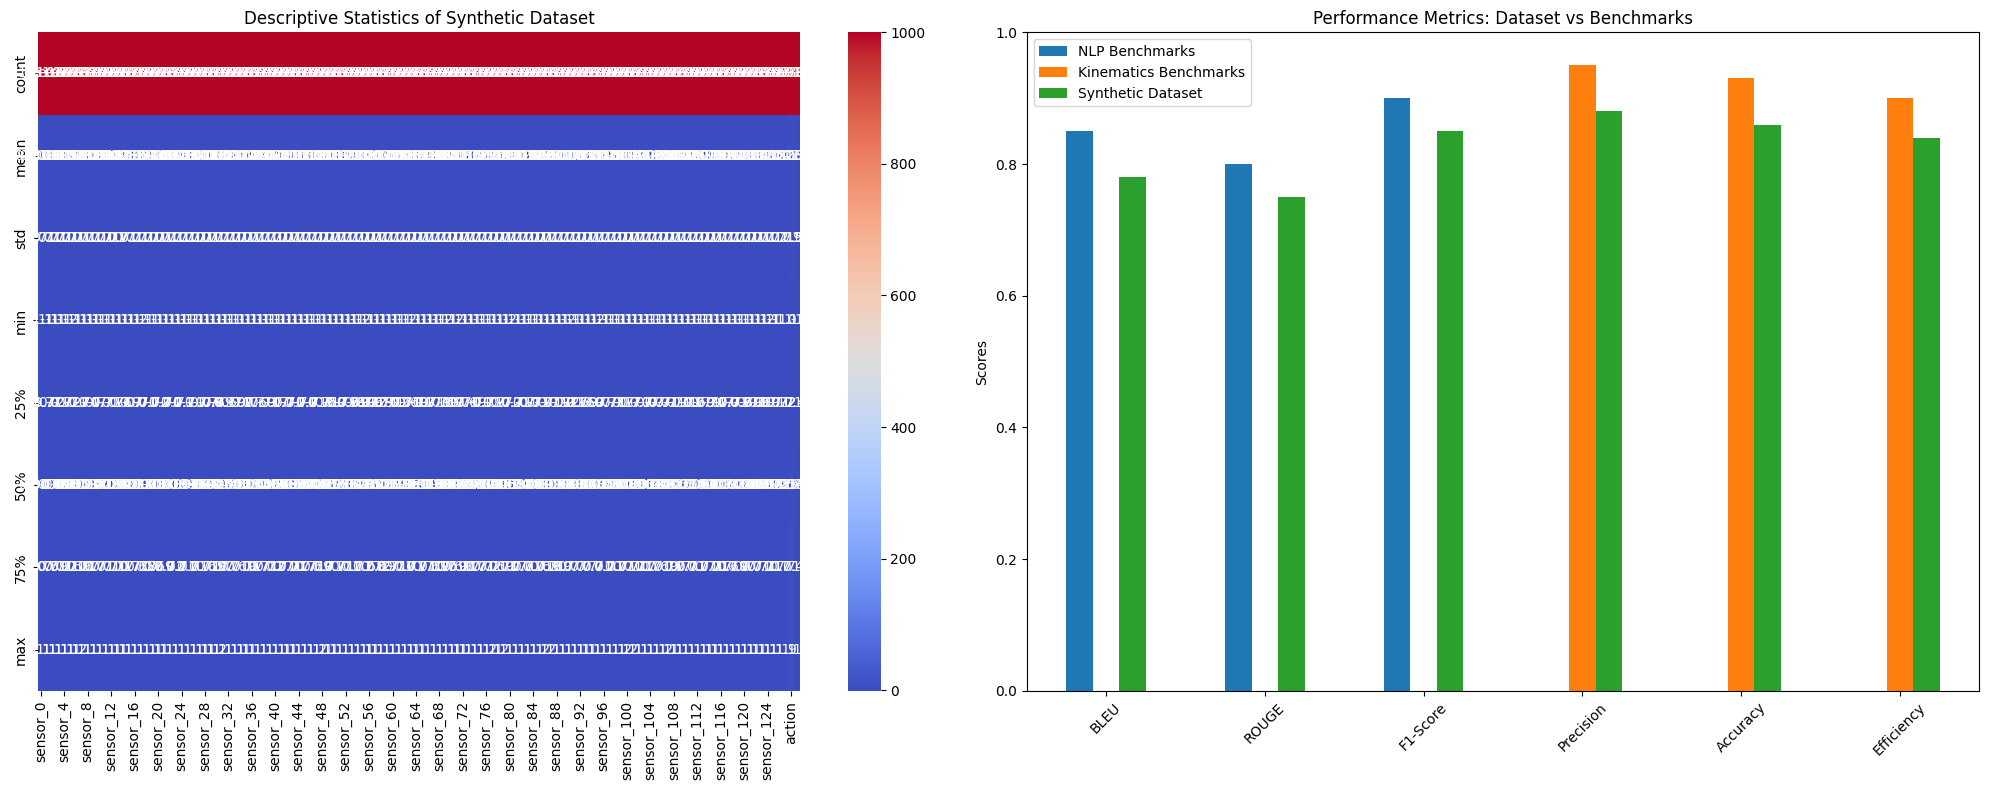

In [18]:
# Placeholder data for benchmarks (Replace with actual values from continuous research)
nlp_benchmarks = {'BLEU': 0.85, 'ROUGE': 0.80, 'F1-Score': 0.90}  # Example NLP benchmarks
kinematics_benchmarks = {'Precision': 0.95, 'Accuracy': 0.93, 'Efficiency': 0.90}  # Example kinematics benchmarks
your_dataset_metrics = {'BLEU': 0.78, 'ROUGE': 0.75, 'F1-Score': 0.85, 'Precision': 0.88, 'Accuracy': 0.86, 'Efficiency': 0.84}

# Convert to DataFrame for visualization
benchmark_df = pd.DataFrame([nlp_benchmarks, kinematics_benchmarks, your_dataset_metrics],
                            index=['NLP Benchmarks', 'Kinematics Benchmarks', 'Synthetic Dataset'])

# Descriptive statistics of the dataset
dataset_stats = df.describe()

# Visualization
plt.figure(figsize=(20, 8))

# Descriptive Statistics Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(dataset_stats, annot=True, cmap='coolwarm')
plt.title('Descriptive Statistics of Synthetic Dataset')

# Benchmark Comparison Bar Chart
plt.subplot(1, 2, 2)
benchmark_df.T.plot(kind='bar', ax=plt.gca())
plt.title('Performance Metrics: Dataset vs Benchmarks')
plt.ylabel('Scores')
plt.ylim(0, 1)  # Normalize score range
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()